In [2]:
# ==============================
# 1. Imports
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer

# Plot style
sns.set(style="whitegrid")

In [3]:
# ==============================
# 2. Load Dataset
# ==============================
ds = load_dataset("hpe-ai/medical-cases-classification-tutorial")

train_df = ds["train"].to_pandas()
val_df   = ds["validation"].to_pandas()
test_df  = ds["test"].to_pandas()

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)
train_df.head()


Repo card metadata block was not found. Setting CardData to empty.


Train: (1724, 5) Val: (370, 5) Test: (370, 5)


,description,transcription,sample_name,medical_specialty,keywords
0,Pacemaker ICD interrogation. Severe nonischem...,"PROCEDURE NOTE: , Pacemaker ICD interrogation....",Pacemaker Interrogation,Cardiovascular / Pulmonary,"cardiovascular / pulmonary, cardiomyopathy, ve..."
1,"Erythema of the right knee and leg, possible s...","PREOPERATIVE DIAGNOSES: , Erythema of the righ...",Aspiration - Knee Joint,Orthopedic,"orthopedic, knee and leg, anterolateral portal..."
2,Left cardiac catheterization with selective ri...,"PREOPERATIVE DIAGNOSIS: , Post infarct angina....",Cardiac Cath & Selective Coronary Angiography,Cardiovascular / Pulmonary,"cardiovascular / pulmonary, selective, angiogr..."
3,Patient with a history of coronary artery dise...,"REASON FOR VISIT: , Acute kidney failure.,HIST...",Acute Kidney Failure,Nephrology,None
4,Cardiac evaluation and treatment in a patient ...,"REASON FOR REFERRAL: , Cardiac evaluation and ...",Cardiac Consultation - 6,Cardiovascular / Pulmonary,None


In [4]:
# ==============================
# 3. Table 2: Dataset Dictionary
# ==============================
data_dict = pd.DataFrame({
    "Feature Name": ["description", "transcription", "sample_name", "medical_specialty", "keywords"],
    "Data Type": ["Text (string)", "Text (string)", "Text (string)", "Categorical (string)", "Text (string)"],
    "Description": [
        "A short summary of the medical case.",
        "Full, detailed transcription of physician’s notes or report.",
        "A title or name for the medical case sample.",
        "Target variable: the medical specialty (13 classes).",
        "List of keywords associated with the case."
    ],
    "Notes / Potential Issues": [
        "Useful as concise feature source.",
        "Primary source, long and complex; requires cleaning, tokenization, TF-IDF.",
        "Likely just an identifier → exclude from training.",
        "Imbalanced distribution → stratify and evaluate with precision/recall/F1.",
        "May be redundant, but useful for feature engineering."
    ]
})

data_dict


,Feature Name,Data Type,Description,Notes / Potential Issues
0,description,Text (string),A short summary of the medical case.,Useful as concise feature source.
1,transcription,Text (string),"Full, detailed transcription of physician’s no...","Primary source, long and complex; requires cle..."
2,sample_name,Text (string),A title or name for the medical case sample.,Likely just an identifier → exclude from train...
3,medical_specialty,Categorical (string),Target variable: the medical specialty (13 cla...,Imbalanced distribution → stratify and evaluat...
4,keywords,Text (string),List of keywords associated with the case.,"May be redundant, but useful for feature engin..."


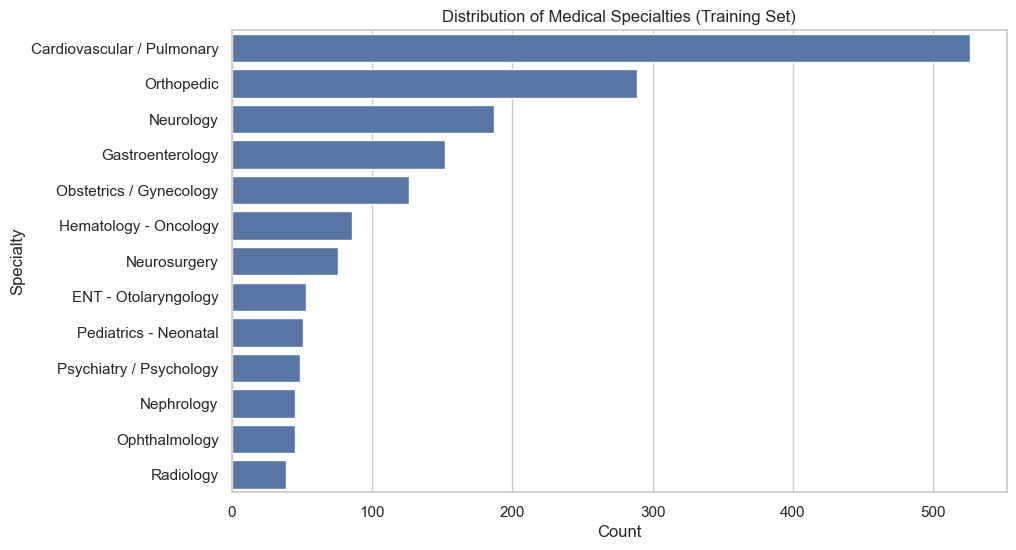

In [5]:
# ==============================
# 4. Target Variable Distribution
# ==============================
plt.figure(figsize=(10,6))
sns.countplot(y="medical_specialty", data=train_df,
              order=train_df["medical_specialty"].value_counts().index)
plt.title("Distribution of Medical Specialties (Training Set)")
plt.xlabel("Count")
plt.ylabel("Specialty")
plt.show()


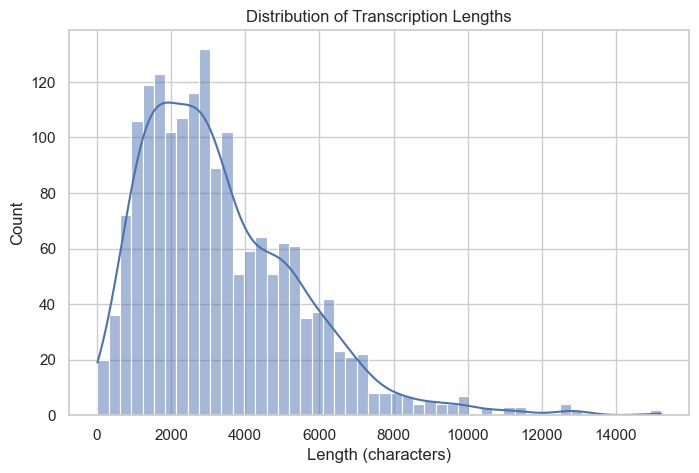

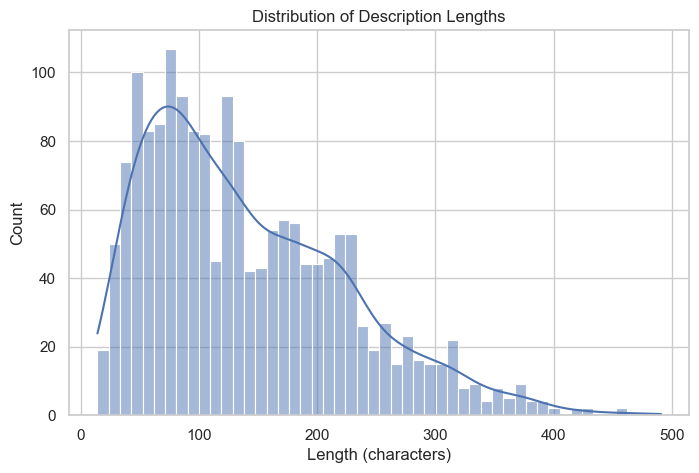

Avg transcription length: 3326.159512761021
Avg description length: 140.4002320185615


In [6]:
# ==============================
# 5. Document Length Analysis
# ==============================
train_df["transcription_length"] = train_df["transcription"].fillna("").apply(len)
train_df["description_length"]   = train_df["description"].fillna("").apply(len)

plt.figure(figsize=(8,5))
sns.histplot(train_df["transcription_length"], bins=50, kde=True)
plt.title("Distribution of Transcription Lengths")
plt.xlabel("Length (characters)")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(train_df["description_length"], bins=50, kde=True)
plt.title("Distribution of Description Lengths")
plt.xlabel("Length (characters)")
plt.show()

print("Avg transcription length:", train_df["transcription_length"].mean())
print("Avg description length:", train_df["description_length"].mean())


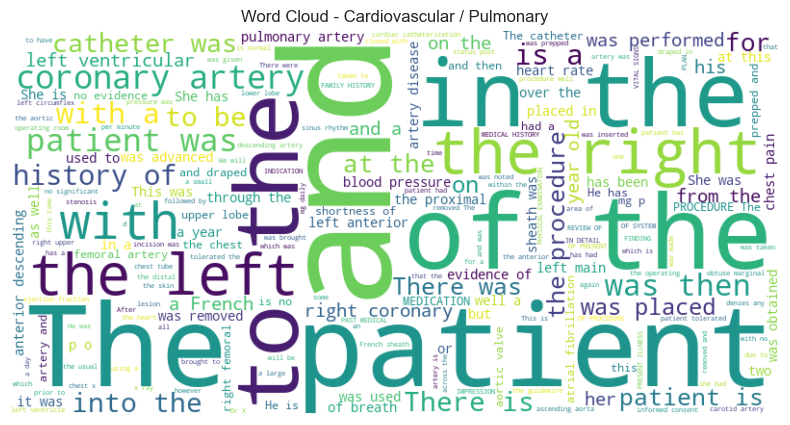

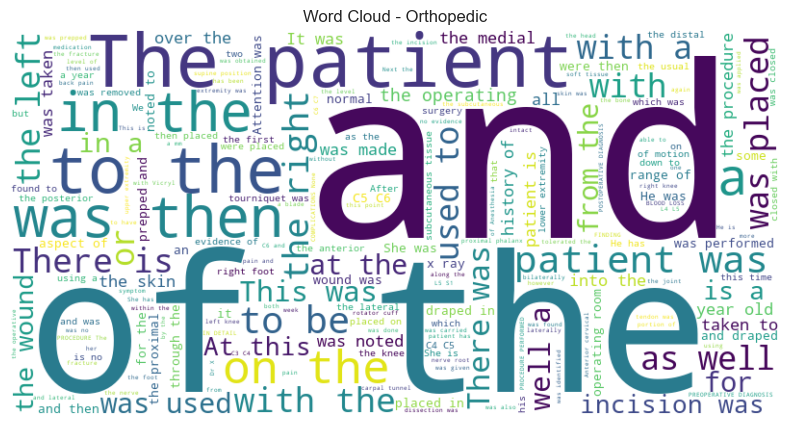

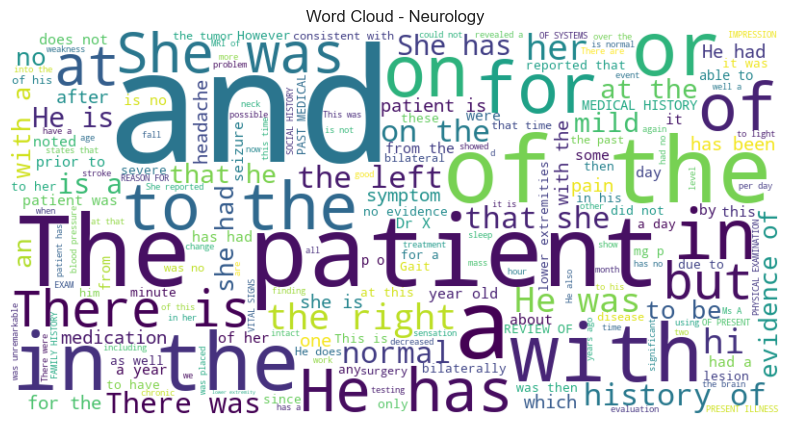

In [7]:
# ==============================
# 6. Word Clouds for Top Specialties
# ==============================
specialties = train_df["medical_specialty"].value_counts().index[:3]  # top 3 specialties
for spec in specialties:
    text = " ".join(train_df[train_df["medical_specialty"]==spec]["transcription"].dropna().astype(str))
    wc = WordCloud(width=800, height=400, background_color="white", stopwords="english").generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - {spec}")
    plt.show()

In [8]:
# ==============================
# 7. Preprocessing Pipeline (TF-IDF)
# ==============================
tfidf = TfidfVectorizer(
    lowercase=True,          # 1. text cleaning
    stop_words="english",    # 2. stop word removal
    ngram_range=(1,2),       # 3. unigrams + bigrams
    max_features=20000       # 4. limit vocab size
)

X_tfidf = tfidf.fit_transform(train_df["transcription"].fillna(""))
print("TF-IDF Matrix Shape:", X_tfidf.shape)


TF-IDF Matrix Shape: (1724, 20000)
